In [29]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

import pandas as pd

In [30]:
df=pd.read_csv("../datas/BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-16,15955.577148,16816.181641,15880.706055,16716.111328,16716.111328,31526766675
1,2020-11-17,16685.691406,17782.919922,16564.544922,17645.406250,17645.406250,39006849170
2,2020-11-18,17645.191406,18393.949219,17352.906250,17804.005859,17804.005859,49064800278
3,2020-11-19,17803.861328,18119.546875,17382.554688,17817.089844,17817.089844,36985055355
4,2020-11-20,17817.083984,18773.226563,17765.794922,18621.314453,18621.314453,36992873940


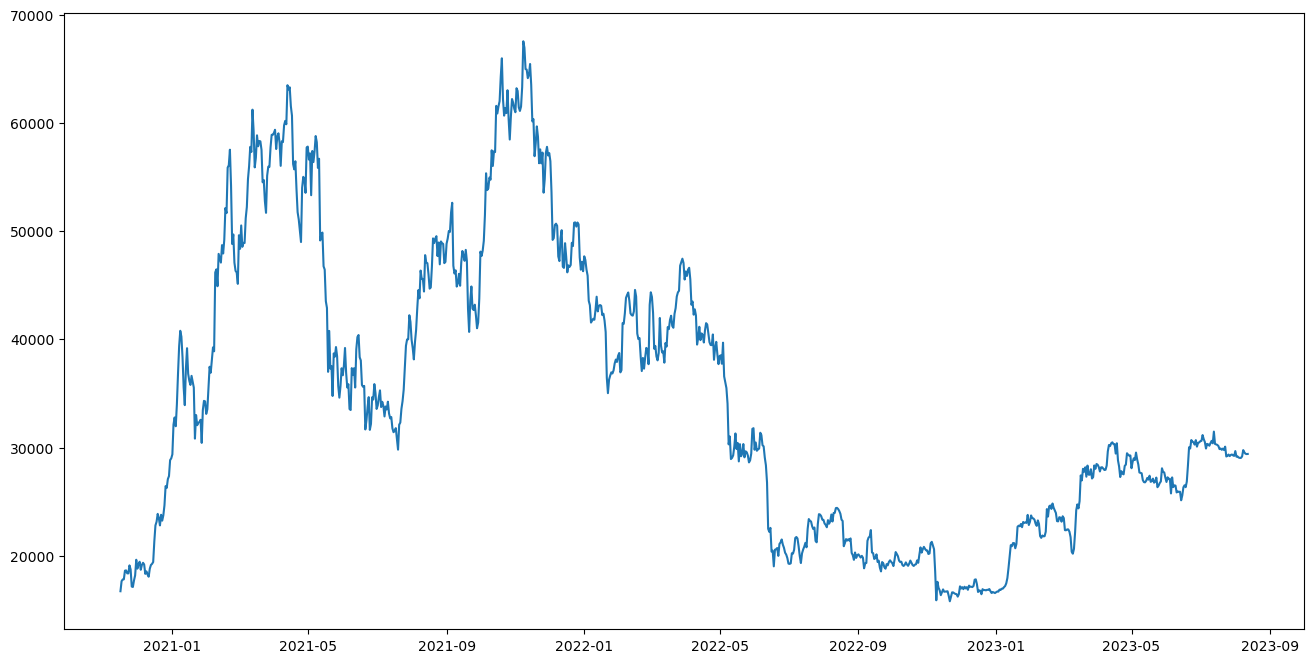

In [31]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [32]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [33]:
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

In [34]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(x_train_data, y_train_data)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
predicted_closing_price=model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price.reshape(-1, 1))


In [36]:
model_filename = "../models/xgboost_model.json"
model.save_model(model_filename)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9080\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


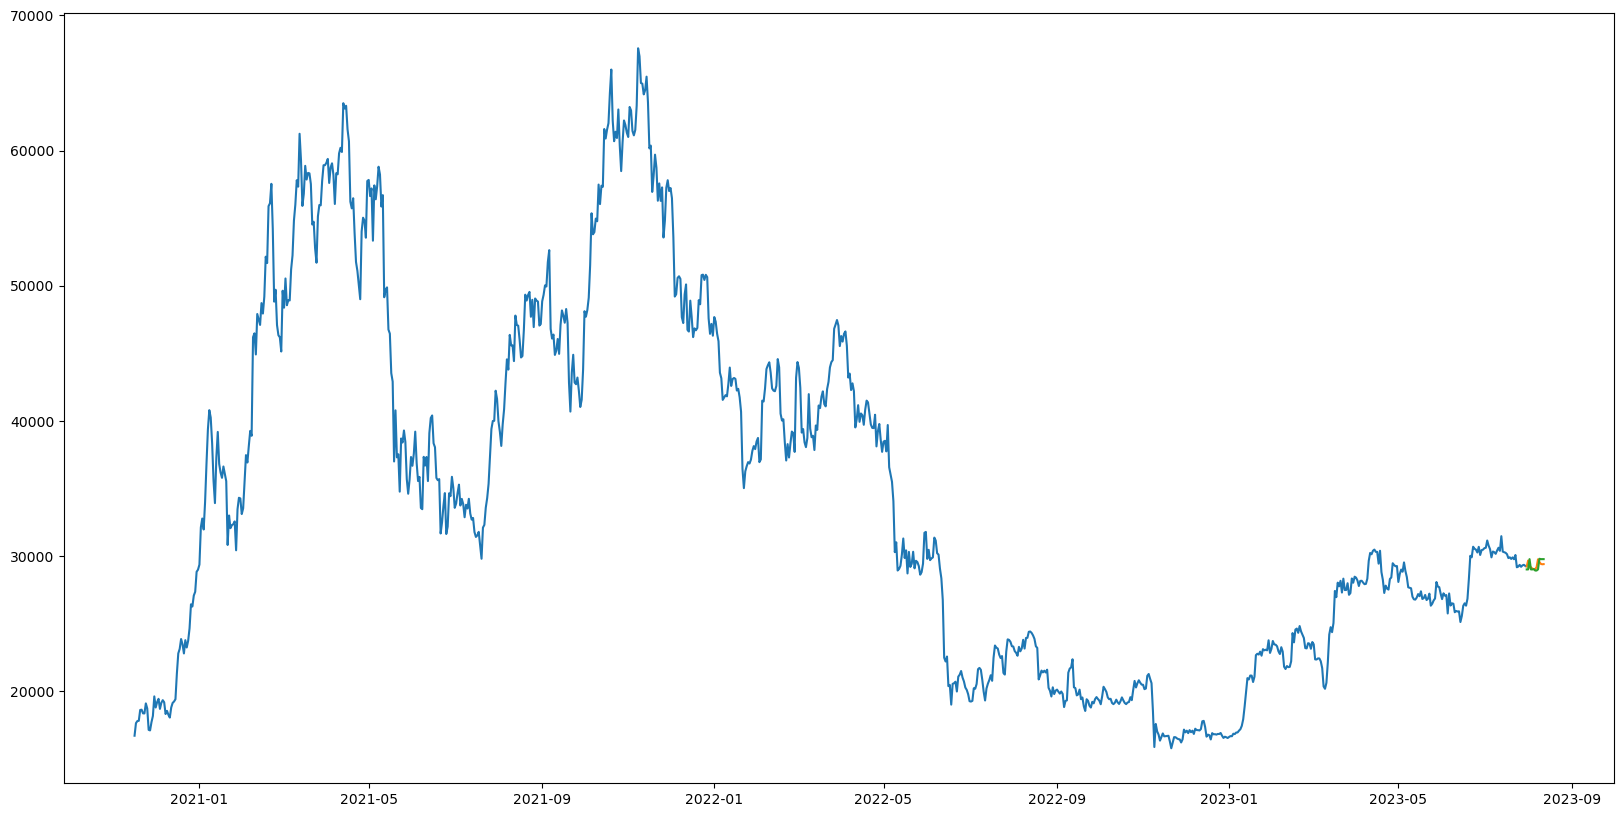

In [37]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])